In [2]:
import datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification

raw_dataset = datasets.load_dataset('eriktks/conll2003')
label_names = raw_dataset['train'].features['ner_tags'].feature.names

num_labels = len(label_names)
id2label = {i:lbl for i, lbl in enumerate(label_names)}
label2id = {lbl:i for i, lbl in enumerate(label_names)}

Using the latest cached version of the dataset since eriktks/conll2003 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/sam/.cache/huggingface/datasets/eriktks___conll2003/default/0.0.0/ce85b39f9dd99f552d0739d456814e95fb6a39b0 (last modified on Wed Nov 26 23:48:03 2025).


In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


def preprocess(batch):
    tokenized_inputs = tokenizer(
        batch['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding=False
    )

    labels = []


    for i, label in enumerate(batch['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)

        previous_id = None

        label_ids = []

        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != previous_id:
                label_ids.append(label[word_id])
            else:
                label_ids.append(-100)
            previous_id = word_id

        labels.append(label_ids)


    tokenized_inputs['labels'] = labels
    return tokenized_inputs

tokenized_dataset = raw_dataset.map(
    preprocess,
    batched=True
)
 
tokenized_dataset

Map: 100%|██████████| 3453/3453 [00:00<00:00, 7229.44 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [4]:
raw_dataset['train'].features['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [5]:
print(tokenized_dataset['train']['labels'][0])
print(tokenized_dataset['train']['tokens'][0])
print(tokenized_dataset['train']['input_ids'][0])


[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]


In [6]:
import evaluate
import numpy as np

metric = evaluate.load('seqeval')

def calculate_metrics(output):
    pred_batch, label_batch = output
    pred_batch = np.argmax(pred_batch, axis=2)

    pred_labels = []
    true_labels = []

    for pred, label in zip(pred_batch, label_batch):
        pred_list = []
        label_list = []
        for p, l in zip(pred, label):
            if l != -100:
                pred_list.append(label_names[p])
                label_list.append(label_names[l])
        pred_labels.append(pred_list)
        true_labels.append(label_list)
    
    result = metric.compute(predictions=pred_labels, references=true_labels)

    return {
        'recall': result['overall_recall'],
        'precision': result['overall_precision'],
        'f1': result['overall_f1'],
        'accuracy': result['overall_accuracy']
    }


In [7]:
from transformers import AutoModelForSequenceClassification



model = AutoModelForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [8]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer) 

In [9]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback


training_args = TrainingArguments(
    output_dir='./ner_output',
    logging_dir='./logs',
    save_strategy="epoch",
    eval_strategy="epoch",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    num_train_epochs=20,
    load_best_model_at_end=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    fp16=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    processing_class=tokenizer,
    compute_metrics=calculate_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Recall,Precision,F1,Accuracy
1,0.193600,0.052602,0.931336,0.921412,0.926348,0.986196
2,0.036200,0.047651,0.950522,0.932167,0.941255,0.988396
3,0.019100,0.047498,0.953214,0.950336,0.951773,0.990012
4,0.011500,0.053635,0.950353,0.938352,0.944314,0.989039
5,0.007900,0.056623,0.947829,0.932759,0.940234,0.988318
6,0.004600,0.061143,0.950017,0.937241,0.943585,0.989019


TrainOutput(global_step=5268, training_loss=0.03593858687282061, metrics={'train_runtime': 478.8027, 'train_samples_per_second': 586.505, 'train_steps_per_second': 36.675, 'total_flos': 2045112348578508.0, 'train_loss': 0.03593858687282061, 'epoch': 6.0})

In [10]:
test_result = trainer.evaluate(tokenized_dataset['test'])
print(test_result)

{'eval_loss': 0.1204412430524826, 'eval_recall': 0.9075779036827195, 'eval_precision': 0.8991405016663743, 'eval_f1': 0.9033395012776455, 'eval_accuracy': 0.9803596425110369, 'eval_runtime': 9.7554, 'eval_samples_per_second': 353.958, 'eval_steps_per_second': 22.142, 'epoch': 6.0}


In [11]:
from transformers import pipeline


model = AutoModelForTokenClassification.from_pretrained('./ner_output/checkpoint-4390')

ner_pipeline = pipeline(
    task='ner',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='first'
)

query = 'Barack Obama and Elon Musk met at Google headquarters in California yesterday.'

ner_pipeline(query)

Device set to use cuda:0


[{'entity_group': 'PER',
  'score': np.float32(0.9980171),
  'word': 'barack obama',
  'start': 0,
  'end': 12},
 {'entity_group': 'PER',
  'score': np.float32(0.8801238),
  'word': 'elon musk',
  'start': 17,
  'end': 26},
 {'entity_group': 'ORG',
  'score': np.float32(0.9980205),
  'word': 'google',
  'start': 34,
  'end': 40},
 {'entity_group': 'LOC',
  'score': np.float32(0.99945587),
  'word': 'california',
  'start': 57,
  'end': 67}]

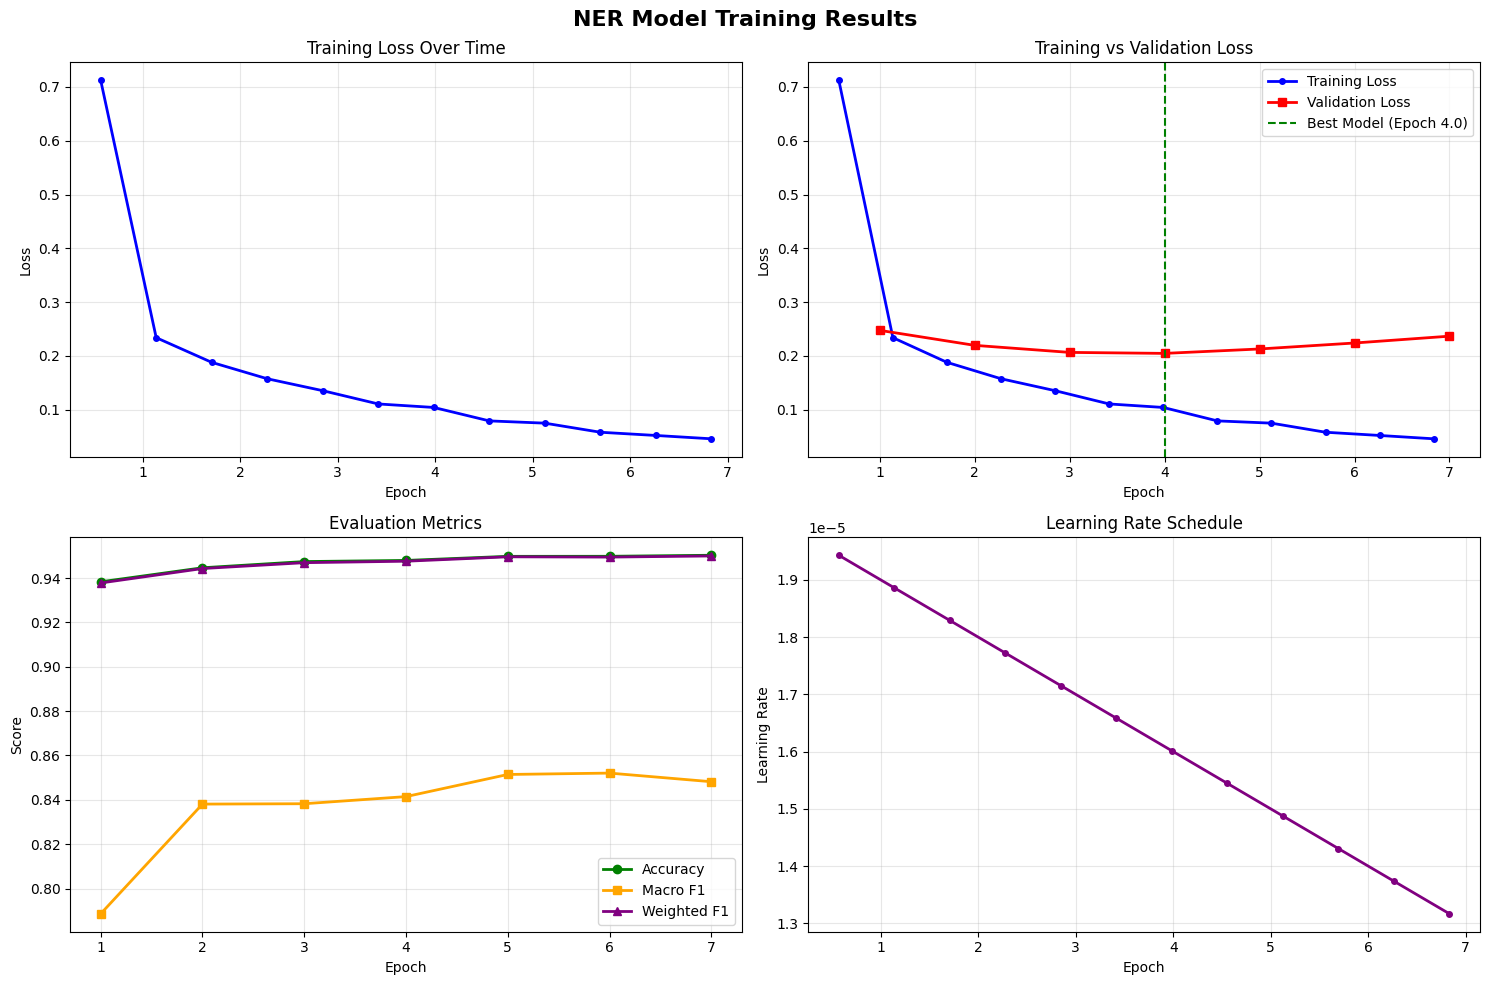

Training Summary
Total Epochs: 7.0
Best Global Step: 3512
Best Validation Loss: 0.2045
Best Model Checkpoint: ./ner_output/checkpoint-3512

Final Metrics (Epoch 7.0):
  Validation Loss: 0.2365
  Validation Accuracy: 0.9503
  Macro F1: 0.8482
  Weighted F1: 0.9500


In [15]:
import matplotlib.pyplot as plt
import json



best_epoch = 'checkpoint-6146'

# Load trainer state
with open(f'./ner_output/{best_epoch}/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

# Extract data from log_history
epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
learning_rates = []

for entry in trainer_state['log_history']:
    if 'loss' in entry:  # Training logs
        epochs.append(entry['epoch'])
        train_loss.append(entry['loss'])
        if 'learning_rate' in entry:
            learning_rates.append(entry['learning_rate'])
    
    if 'eval_loss' in entry:  # Evaluation logs
        eval_epochs = [entry['epoch']]
        if eval_loss:
            eval_epochs = [e['epoch'] for e in trainer_state['log_history'] if 'eval_loss' in e]
            eval_loss_vals = [e['eval_loss'] for e in trainer_state['log_history'] if 'eval_loss' in e]
            eval_acc_vals = [e['eval_accuracy'] for e in trainer_state['log_history'] if 'eval_accuracy' in e]
            eval_f1_vals = [e['eval_macro_f1'] for e in trainer_state['log_history'] if 'eval_macro_f1' in e]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('NER Model Training Results', fontsize=16, fontweight='bold')

# Plot 1: Training Loss
ax1 = axes[0, 0]
ax1.plot(epochs, train_loss, 'b-', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)

# Plot 2: Training & Validation Loss
ax2 = axes[0, 1]
eval_epochs = [e['epoch'] for e in trainer_state['log_history'] if 'eval_loss' in e]
eval_loss_vals = [e['eval_loss'] for e in trainer_state['log_history'] if 'eval_loss' in e]
ax2.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
ax2.plot(eval_epochs, eval_loss_vals, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=6)
ax2.axvline(x=trainer_state['best_global_step']/878, color='g', linestyle='--', label=f'Best Model (Epoch {trainer_state["best_global_step"]/878:.1f})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training vs Validation Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Evaluation Metrics (Accuracy & F1)
ax3 = axes[1, 0]
eval_acc_vals = [e['eval_accuracy'] for e in trainer_state['log_history'] if 'eval_accuracy' in e]
eval_macro_f1 = [e['eval_macro_f1'] for e in trainer_state['log_history'] if 'eval_macro_f1' in e]
eval_weighted_f1 = [e['eval_weighted_f1'] for e in trainer_state['log_history'] if 'eval_weighted_f1' in e]
ax3.plot(eval_epochs, eval_acc_vals, 'g-', linewidth=2, label='Accuracy', marker='o', markersize=6)
ax3.plot(eval_epochs, eval_macro_f1, 'orange', linewidth=2, label='Macro F1', marker='s', markersize=6)
ax3.plot(eval_epochs, eval_weighted_f1, 'purple', linewidth=2, label='Weighted F1', marker='^', markersize=6)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.set_title('Evaluation Metrics')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Learning Rate Schedule
ax4 = axes[1, 1]
lr_epochs = [e['epoch'] for e in trainer_state['log_history'] if 'learning_rate' in e]
lr_vals = [e['learning_rate'] for e in trainer_state['log_history'] if 'learning_rate' in e]
ax4.plot(lr_epochs, lr_vals, 'purple', linewidth=2, marker='o', markersize=4)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule')
ax4.grid(True, alpha=0.3)
ax4.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=" * 60)
print("Training Summary")
print("=" * 60)
print(f"Total Epochs: {trainer_state['epoch']}")
print(f"Best Global Step: {trainer_state['best_global_step']}")
print(f"Best Validation Loss: {trainer_state['best_metric']:.4f}")
print(f"Best Model Checkpoint: {trainer_state['best_model_checkpoint']}")
print(f"\nFinal Metrics (Epoch {trainer_state['epoch']}):")
final_eval = [e for e in trainer_state['log_history'] if 'eval_loss' in e][-1]
print(f"  Validation Loss: {final_eval['eval_loss']:.4f}")
print(f"  Validation Accuracy: {final_eval['eval_accuracy']:.4f}")
print(f"  Macro F1: {final_eval['eval_macro_f1']:.4f}")
print(f"  Weighted F1: {final_eval['eval_weighted_f1']:.4f}")
print("=" * 60)